# PARK VISITATION PREDICTOR BASED ON REAL WEATHER DATA

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import shap
pd.options.mode.chained_assignment = None

In [43]:
df= pd.read_csv("/Users/saipraneeth/Downloads/Environics Analytics Internship Assignment.csv")
visits= pd.read_csv("/Users/saipraneeth/Downloads/Environics Analytics Visitations.csv")
df.rename(columns = {'DATE_CALENDAR':'DATE'}, inplace = True) 
data = pd.merge(df,visits,on='DATE') #Inner Join
data

DATE  CLOUD_BASE_HEIGHT_24HR_DEP  CLOUD_BASE_HEIGHT_AVG  \
0    2021-04-01                        -438                 1552.0   
1    2021-04-02                       10639                    NaN   
2    2021-04-03                       -8806                 3385.0   
3    2021-04-04                        4162                 7547.0   
4    2021-04-05                       -3140                 4407.0   
..          ...                         ...                    ...   
359  2022-03-27                          44                 1040.0   
360  2022-03-28                        -155                  884.0   
361  2022-03-29                         170                 1055.0   
362  2022-03-30                        2549                 3604.0   
363  2022-03-31                       -2655                  949.0   

     CLOUD_BASE_HEIGHT_MAX  CLOUD_BASE_HEIGHT_MIN  CLOUD_COVER_24HR_DEP  \
0                   2709.0                  726.0                 -0.64   
1                      NaN                    NaN                 -0.30   
2                   5141.0                 1709.0                  0.53   
3                   7714.0                 7380.0                 -0.48   
4                   5151.0                 3748.0                  0.41   
..                     ...                    ...                   ...   
359                 1348.0                  566.0                  0.15   
360                 1055.0                  660.0                 -0.13   
361                 1266.0                  757.0                 -0.45   
362                 9458.0                  657.0                  0.63   
363                 3086.0                   30.0                 -0.27   

     CLOUD_COVER_AVG  CLOUD_COVER_MAX  CLOUD_COVER_MIN  \
0               0.30             0.94             0.00   
1               0.00             0.00             0.00   
2               0.53             1.00             0.00   
3               0.05             0.60             0.00   
4               0.46             0.99             0.00   
..               ...              ...              ...   
359             0.96             1.00             0.48   
360             0.82             1.00             0.38   
361             0.37             0.98             0.00   
362             1.00             1.00             0.99   
363             0.73             1.00             0.08   

     CLOUD_COVER_PERC_24HR_DEP  ...  WIND_GUST_MIN  \
0                          -63  ...           9.79   
1                          -29  ...           5.53   
2                           53  ...           3.04   
3                          -48  ...           2.38   
4                           41  ...           2.91   
..                         ...  ...            ...   
359                         15  ...           9.78   
360                        -13  ...           9.18   
361                        -45  ...           3.96   
362                         62  ...           3.88   
363                        -26  ...           4.33   

     WIND_GUST_INSTANTANEOUS_24HR_DEP  WIND_GUST_INSTANTANEOUS_AVG  \
0                                4.26                        12.22   
1                               -2.64                         9.57   
2                               -3.34                         6.24   
3                               -2.18                         4.05   
4                                0.05                         4.10   
..                                ...                          ...   
359                              4.52                        13.18   
360                             -1.03                        12.15   
361                             -5.74                         6.41   
362                              2.59                         9.00   
363                              2.14                        11.14   

     WIND_GUST_INSTANTANEOUS_MAX  WIND_GUST_INSTANTANEOUS_MIN  \
0                

In [4]:
data.to_csv('Merged Data.csv',index = False)

# Cleaning Data

The first and foremost step would be cleaning the data.
1. Dealing with Missing values
2. Converting categorical features to numeric features.
3. Getting rid of outliers if any

It is not just the feature outliers that we should remove, even the target outliers, so let's have a look at the scatter plot of visits per day.

Text(0.5, 1.0, 'Visitation Percentage by DATE')

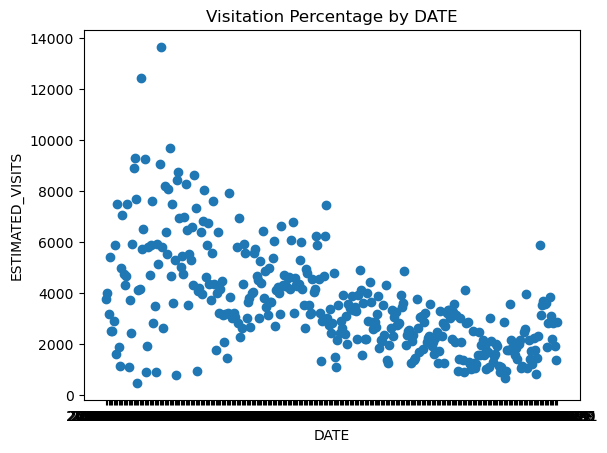

In [44]:
plt.scatter(data['DATE'],data['ESTIMATED_VISITS'])
plt.xlabel('DATE')
plt.ylabel('ESTIMATED_VISITS')
plt.title('Visitation Percentage by DATE')

It appears that there are two data points that significantly deviate from the rest, acting as outliers. We should consider removing them from the dataset.

In [45]:
np.where(data['ESTIMATED_VISITS']>10000)

(array([28, 44]),)

In [46]:
data.drop([44,28],inplace = True)

Let's assess the extent of missing values present in this merged dataset. We'll iterate through the features and print each feature's name along with the percentage of missing values it contains.

In [47]:
features_with_na=[features for features in data.columns if data[features].isnull().sum()>1]
for feature in features_with_na:
    print(feature, (np.round(data[feature].isnull().mean(), 4)))

CLOUD_BASE_HEIGHT_AVG 0.0138
CLOUD_BASE_HEIGHT_MAX 0.0138
CLOUD_BASE_HEIGHT_MIN 0.0138
PRECIPITATION_INTENSITY_MAX 0.6188
TEMPERATURE_HEAT_INDEX_24HR_DEP 0.9392
TEMPERATURE_HEAT_INDEX_AVG 0.9088
TEMPERATURE_HEAT_INDEX_MAX 0.9088
TEMPERATURE_HEAT_INDEX_MIN 0.9088
TEMPERATURE_WIND_CHILL_24HR_DEP 0.4309
TEMPERATURE_WIND_CHILL_AVG 0.4199
TEMPERATURE_WIND_CHILL_MAX 0.4199
TEMPERATURE_WIND_CHILL_MIN 0.4199


In [48]:
#dropping the columns with less than 80%
threshold = len(data) * 0.8
low_fill_columns = []
for column in data.columns:
    non_null_count = data[column].notnull().sum()
    if non_null_count < threshold:
        low_fill_columns.append(column)
print("Columns with less than 80% fill rate:", low_fill_columns)
data.drop(low_fill_columns, axis=1, inplace=True)

Columns with less than 80% fill rate: ['PRECIPITATION_INTENSITY_MAX', 'TEMPERATURE_HEAT_INDEX_24HR_DEP', 'TEMPERATURE_HEAT_INDEX_AVG', 'TEMPERATURE_HEAT_INDEX_MAX', 'TEMPERATURE_HEAT_INDEX_MIN', 'TEMPERATURE_WIND_CHILL_24HR_DEP', 'TEMPERATURE_WIND_CHILL_AVG', 'TEMPERATURE_WIND_CHILL_MAX', 'TEMPERATURE_WIND_CHILL_MIN']


In [49]:
data = data.loc[:, (data != 0).any(axis=0)]
#Certain boolean features are string , therefore converting them boolean value.
for col in data.columns:
    if set(data[col].unique()) <= {'True', 'False', True, False}:
        data[col] = data[col].replace({'True': True, 'False': False}).astype(bool).astype(int)

In [50]:
# print(data['PRECIPITATION_INTENSITY_MAX'].value_counts())
print(data['PRECIPITATION_TYPE_DESC_PREDOMINANT'].value_counts())
print(data['SNOW_DRIFTING_INTENSITY_MAX'].value_counts())
print(data['SNOW_TYPE_DESC_PREDOMINANT'].value_counts())

No precipitation    358
Rain                  4
Name: PRECIPITATION_TYPE_DESC_PREDOMINANT, dtype: int64
None        358
Moderate      2
Light         2
Name: SNOW_DRIFTING_INTENSITY_MAX, dtype: int64
None    362
Name: SNOW_TYPE_DESC_PREDOMINANT, dtype: int64


In [51]:
#Dropping columns with None values. 
data.drop(['PRECIPITATION_TYPE_DESC_PREDOMINANT', 'SNOW_DRIFTING_INTENSITY_MAX','SNOW_TYPE_DESC_PREDOMINANT'], axis=1, inplace=True)

In [52]:
#checking the columns with nulls
columns_with_nulls = data.columns[data.isnull().any()].tolist()
print("Columns with null values:", columns_with_nulls)

Columns with null values: ['CLOUD_BASE_HEIGHT_AVG', 'CLOUD_BASE_HEIGHT_MAX', 'CLOUD_BASE_HEIGHT_MIN']


Since all the three features are cloud base height related, let's try to calculate the correlation between these features before dropping them 

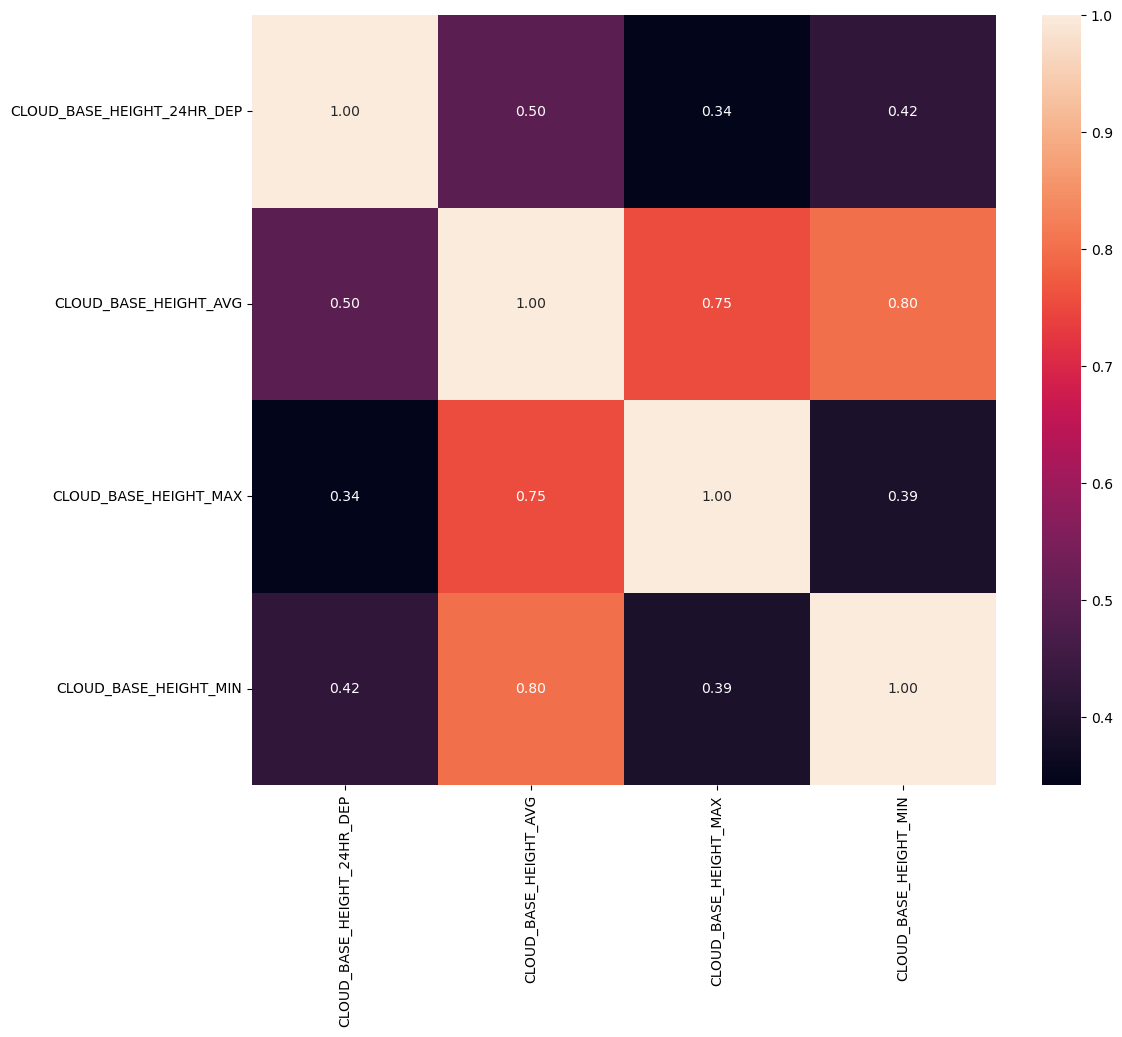

In [53]:
selected_features = data[['CLOUD_BASE_HEIGHT_24HR_DEP','CLOUD_BASE_HEIGHT_AVG', 'CLOUD_BASE_HEIGHT_MAX', 'CLOUD_BASE_HEIGHT_MIN']]
correlation_matrix = selected_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

In [54]:
data.drop(['CLOUD_BASE_HEIGHT_AVG'],axis=1, inplace=True) #Because the Correlation is high in the above image

In [55]:
#But still do have some missing values, so let's just drop the rows that have null values.
data.dropna(subset=['CLOUD_BASE_HEIGHT_24HR_DEP', 'CLOUD_BASE_HEIGHT_MAX', 'CLOUD_BASE_HEIGHT_MIN'], inplace = True)
data

DATE  CLOUD_BASE_HEIGHT_24HR_DEP  CLOUD_BASE_HEIGHT_MAX  \
0    2021-04-01                        -438                 2709.0   
2    2021-04-03                       -8806                 5141.0   
3    2021-04-04                        4162                 7714.0   
4    2021-04-05                       -3140                 5151.0   
5    2021-04-06                       -1298                 8255.0   
..          ...                         ...                    ...   
359  2022-03-27                          44                 1348.0   
360  2022-03-28                        -155                 1055.0   
361  2022-03-29                         170                 1266.0   
362  2022-03-30                        2549                 9458.0   
363  2022-03-31                       -2655                 3086.0   

     CLOUD_BASE_HEIGHT_MIN  CLOUD_COVER_24HR_DEP  CLOUD_COVER_AVG  \
0                    726.0                 -0.64             0.30   
2                   1709.0                  0.53             0.53   
3                   7380.0                 -0.48             0.05   
4                   3748.0                  0.41             0.46   
5                   1728.0                  0.09             0.55   
..                     ...                   ...              ...   
359                  566.0                  0.15             0.96   
360                  660.0                 -0.13             0.82   
361                  757.0                 -0.45             0.37   
362                  657.0                  0.63             1.00   
363                   30.0                 -0.27             0.73   

     CLOUD_COVER_MAX  CLOUD_COVER_MIN  CLOUD_COVER_PERC_24HR_DEP  \
0               0.94             0.00                        -63   
2               1.00             0.00                         53   
3               0.60             0.00                        -48   
4               0.99             0.00                         41   
5               1.00             0.00                          9   
..               ...              ...                        ...   
359             1.00             0.48                         15   
360             1.00             0.38                        -13   
361             0.98             0.00                        -45   
362             1.00             0.99                         62   
363             1.00             0.08                        -26   

     CLOUD_COVER_PERC_AVG  ...  WIND_GUST_MIN  \
0                      29  ...           9.79   
2                      53  ...           3.04   
3                       4  ...           2.38   
4                      46  ...           2.91   
5                      55  ...           3.26   
..                    ...  ...            ...   
359                    95  ...           9.78   
360                    82  ...           9.18   
361                    37  ...           3.96   
362                    99  ...           3.88   
363                    73  ...           4.33   

     WIND_GUST_INSTANTANEOUS_24HR_DEP  WIND_GUST_INSTANTANEOUS_AVG  \
0                                4.26                        12.22   
2                               -3.34                         6.24   
3                               -2.18                         4.05   
4                                0.05                         4.10   
5                                1.49                         5.59   
..                                ...                          ...   
359                              4.52                        13.18   
360                             -1.03                        12.15   
361                             -5.74                         6.41   
362                              2.59                         9.00   
363                              2.14                        11.14   

     WIND_GUST_INSTANTANEOUS_MAX  WIND_GUST_INSTANTANEOUS_MIN  \
0                          15

In [17]:
data.to_csv("unCleanedData.csv", index=False)

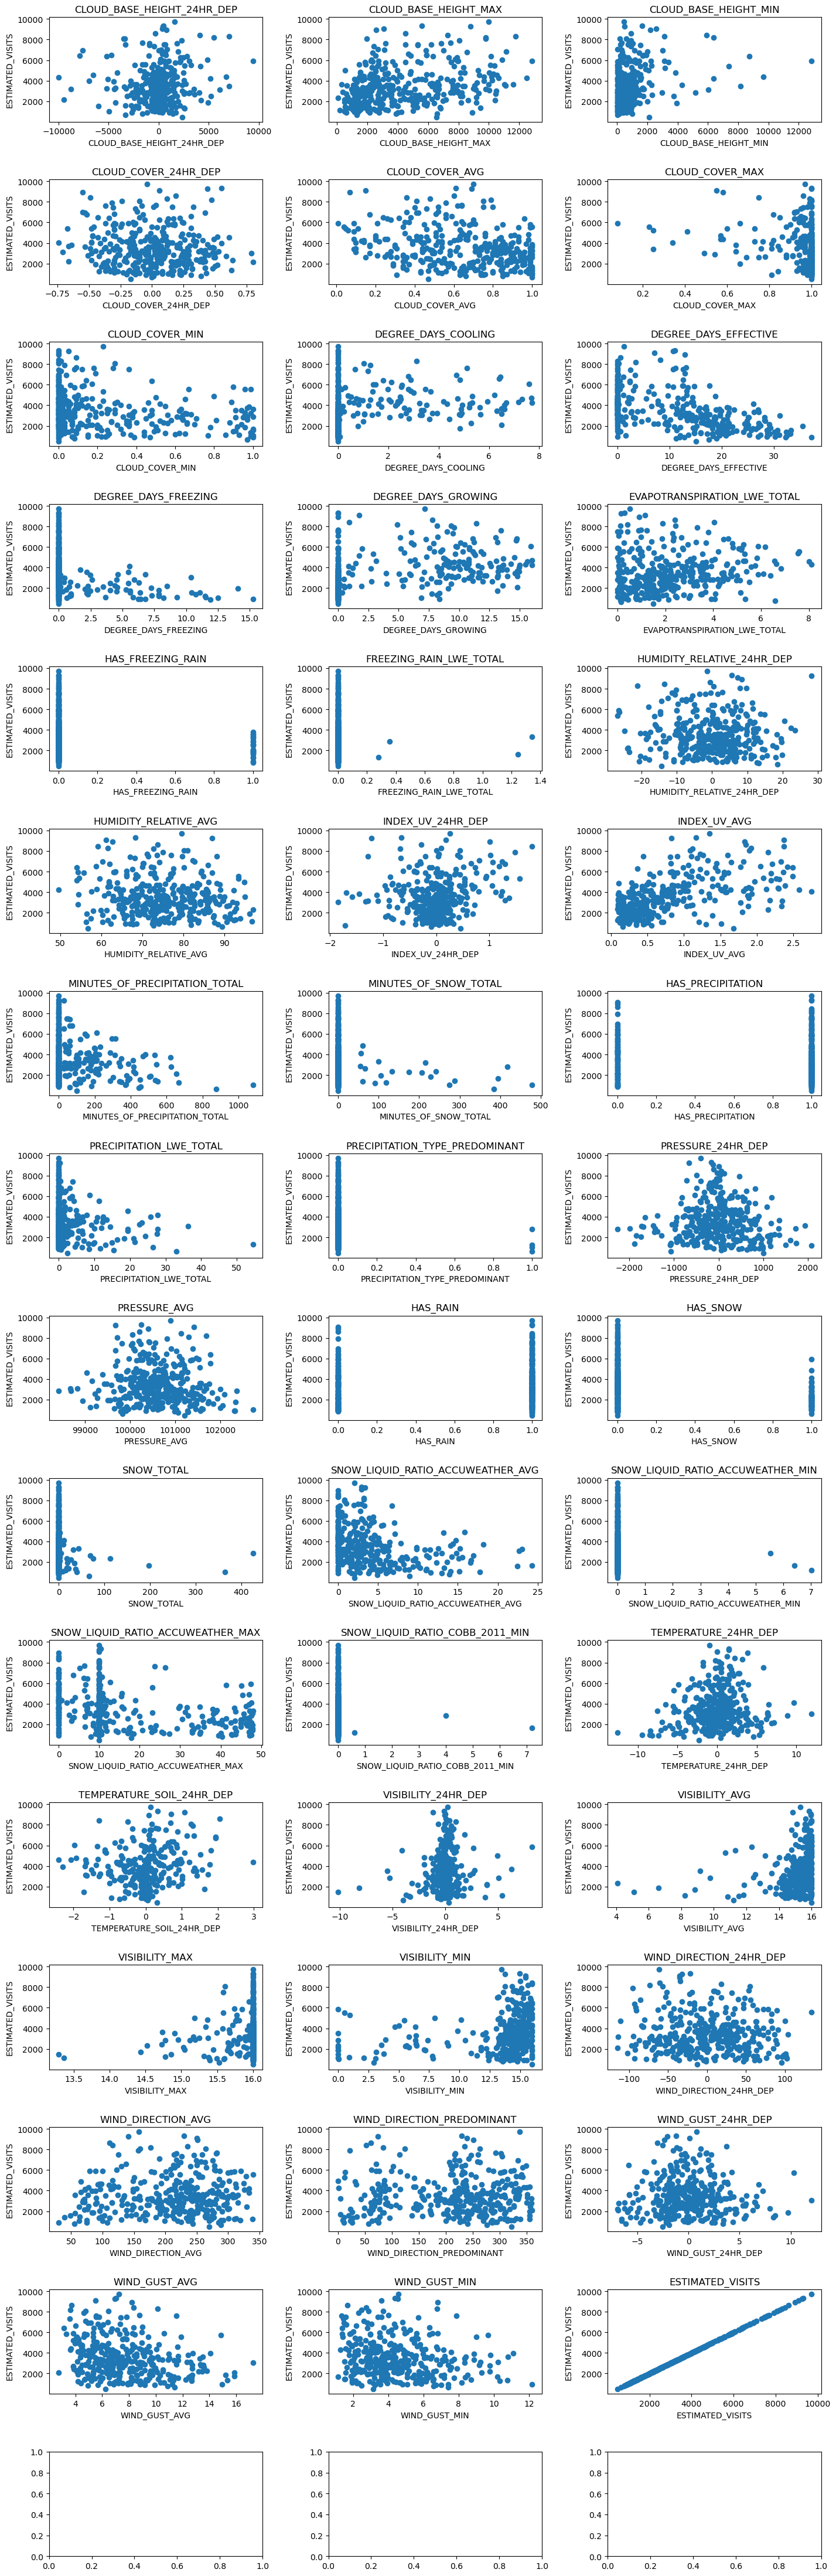

In [160]:
num_columns = len(data.columns)
fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, num_columns)) 
fig.tight_layout(pad=5.0)

for i, col in enumerate(data.columns):
    ax = axes.flatten()[i]
    data_copy = data.copy()
    y = data['ESTIMATED_VISITS']
    ax.scatter(data_copy[col], y)
    ax.set_xlabel(col)
    ax.set_ylabel('ESTIMATED_VISITS')
    ax.set_title(col)

plt.show()

As we examine the scatter plots, it becomes apparent that some features contain outliers. We'll address these outliers as needed after completing EDA on this dataset.

# EDA [Exploratory Data Analysis]
In this section, we'll delve into the provided features and assess how they influence the estimated visitation data. We'll begin by conducting Pearson's correlation analysis and then filter out features that surpass the predetermined correlation threshold.

In [154]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
#     print(corr_matrix)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr

In [156]:
corr_features = correlation(data, 0.85)

In [59]:
len(corr_features)

88

We drop these 88 features as they are highly correlated. 

In [60]:
data.drop(corr_features,axis=1,inplace =True)

Let's further plot the correlation matrix for the remaining features and try to understand if there are any high correlated features

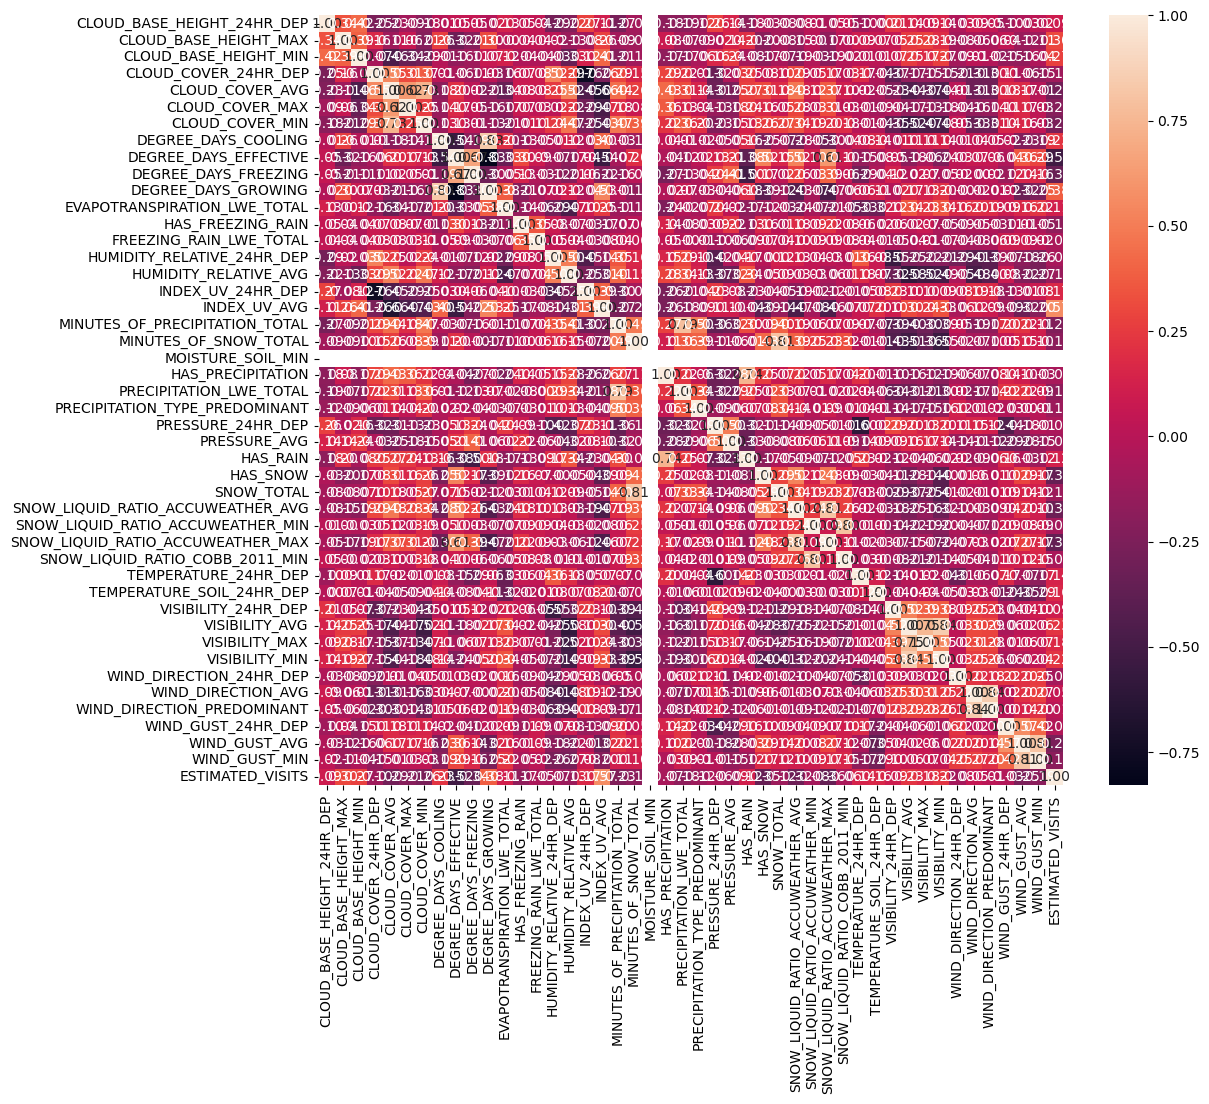

In [61]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

In [62]:
data.drop(['MOISTURE_SOIL_MIN','DATE'],axis=1, inplace=True) #Because the Correlation is high in the above image

In [63]:
data.to_csv("CleanedData.csv", index=False)

### Creating Insights for certain features

The correlated features matrix provides a comprehensive examination of various factors, including Index_UV, VISIBILITY, WIND_GUST, SNOW_LIQUID_RATIO, HUMIDITY, TEMPERATURE, CLOUD_COVER, and PRESSURE_AVG, and their impact on estimated visits. This analysis is detailed in the "EDA Insights" file, which highlights key insights and also offers recommendations to enhance visitation numbers based on the identified features.

## Categorical Value chi2 Test 

In [64]:
#Choosing the categorical features alone to perform chisquare test.
df_cat = data[['HAS_RAIN', 'HAS_SNOW', 'HAS_FREEZING_RAIN', 'HAS_PRECIPITATION', 'PRECIPITATION_TYPE_PREDOMINANT']]

In [65]:
df_cat.isnull().sum()

HAS_RAIN                          0
HAS_SNOW                          0
HAS_FREEZING_RAIN                 0
HAS_PRECIPITATION                 0
PRECIPITATION_TYPE_PREDOMINANT    0
dtype: int64

In [66]:
chi2_stats, p_values=chi2(df_cat,data['ESTIMATED_VISITS'])

In [67]:
p_values=pd.Series(p_values)
p_values.index=df_cat.columns
p_values

HAS_RAIN                          1.000000
HAS_SNOW                          0.993059
HAS_FREEZING_RAIN                 0.844043
HAS_PRECIPITATION                 1.000000
PRECIPITATION_TYPE_PREDOMINANT    0.371620
dtype: float64

Clearly the best value to pick from the above p_values would be to choose "PRECIPITATION_TYPE_PREDOMINANT"  alone as it has less p-value. 

### Distributions

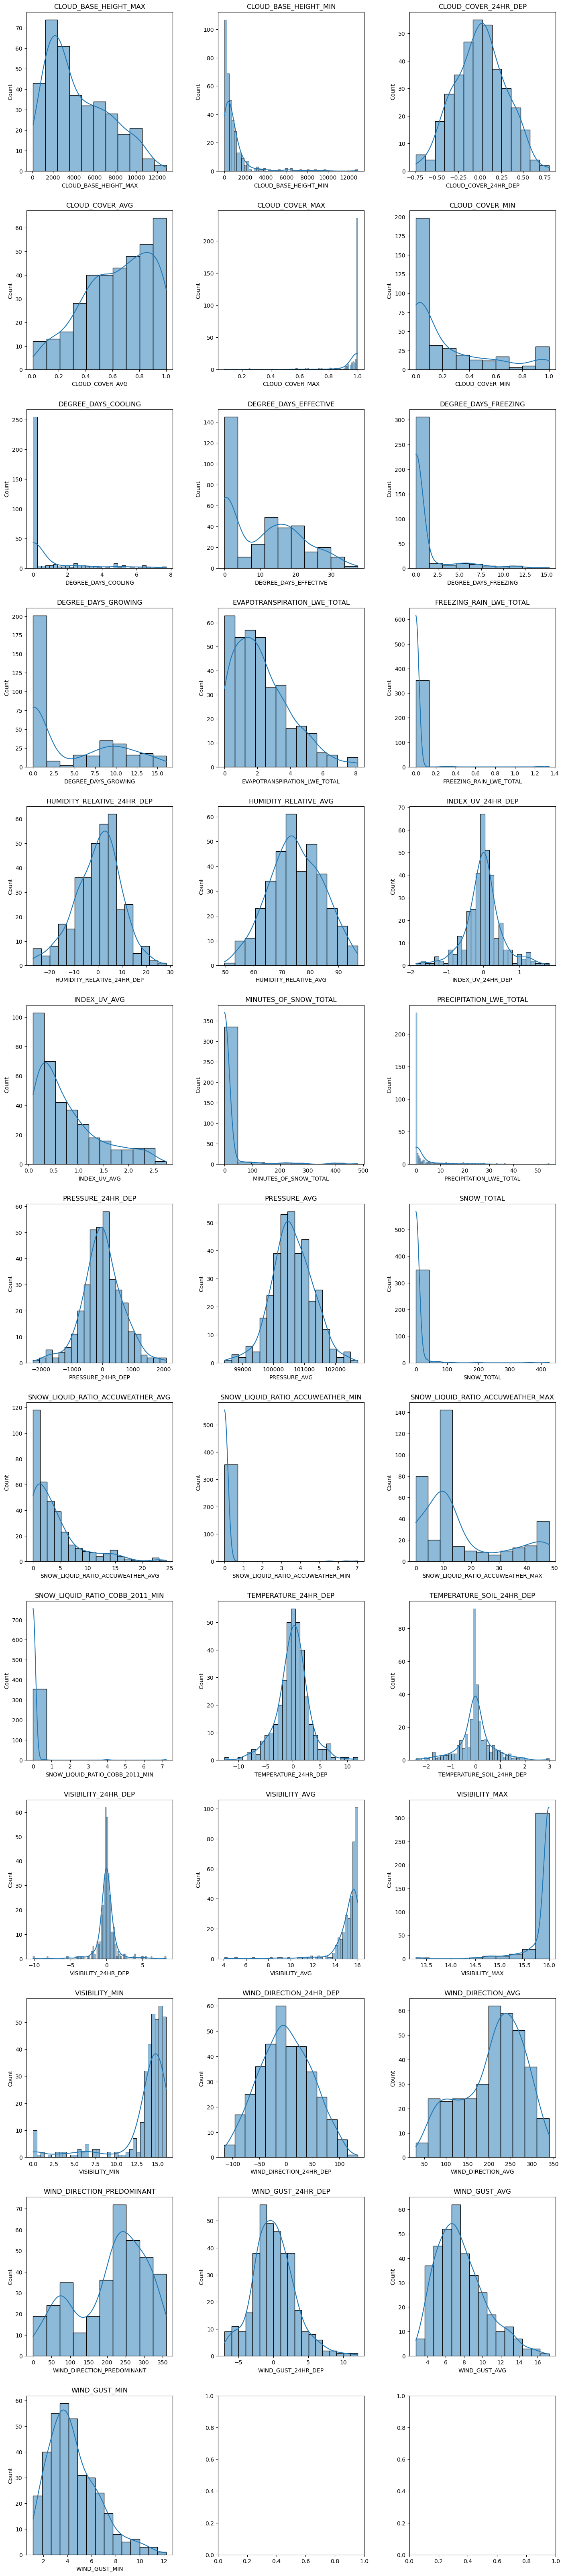

In [158]:
numerical_columns = [col for col in data.columns if data[col].dtypes != 'int64']
num_plots = len(numerical_columns)
num_cols = 3  
num_rows = (num_plots + num_cols - 1) // num_cols  
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))  
fig.tight_layout(pad=5.0)  
for i, col in enumerate(non_int64_columns):
    ax = axes.flatten()[i]
    sns.histplot(data[col], kde=True, ax=ax) 
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.set_title(col)
plt.show()

# Feature selection  
In this section, we will perform three different feature selection methods and finally choose the top features to perform the predictive analysis
1. Mutual Information Regression
2. SHAP on simple Regression to obtain the feature importance
3. Decision Tree Regression 

Let's start with the first method:

1. Mutual Information Regression method to find the top features

In [69]:
X_train,X_test,y_train,y_test=train_test_split(data.drop(labels=['ESTIMATED_VISITS'], axis=1),
    data['ESTIMATED_VISITS'],
    test_size=0.1,
    random_state=42)

In [70]:
# determine the mutual information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info

array([0.03399866, 0.02193986, 0.        , 0.        , 0.14977373,
       0.046241  , 0.02547526, 0.11471379, 0.24441314, 0.11360086,
       0.16793106, 0.01433723, 0.02246132, 0.00129579, 0.        ,
       0.        , 0.07149018, 0.21950038, 0.04218135, 0.01410995,
       0.        , 0.01655321, 0.00633308, 0.10732392, 0.00641039,
       0.        , 0.08800014, 0.00977762, 0.11322601, 0.00206711,
       0.11500316, 0.00240561, 0.00915945, 0.14976209, 0.00048958,
       0.01958826, 0.03122935, 0.08195831, 0.        , 0.07678603,
       0.06158569, 0.02994662, 0.03616557, 0.03326109])

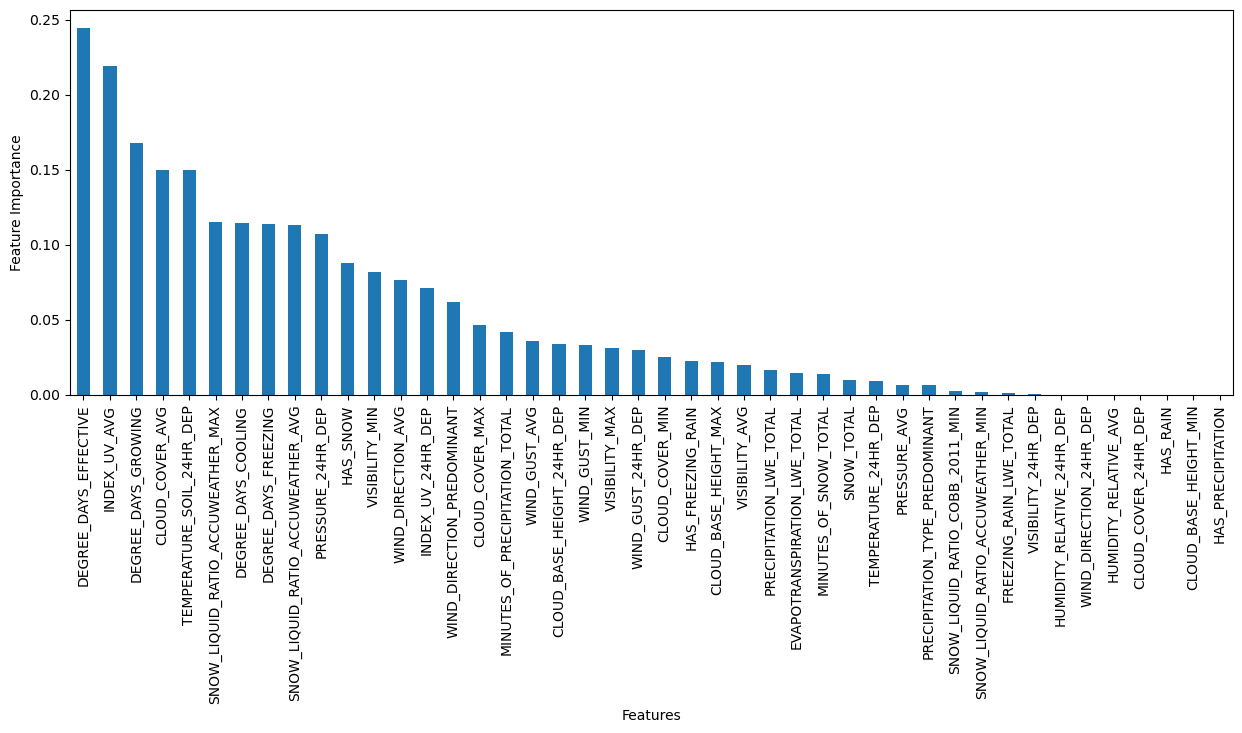

In [71]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
sorted_mutual_info =mutual_info.sort_values(ascending=False)
sorted_mutual_info.plot.bar(figsize=(15,5))
plt.ylabel('Feature Importance')
plt.xlabel('Features')
#Creating a dataframe to use this information later on to perform intersection of three models
important_features_mutual_info = pd.DataFrame({
    'Feature': sorted_mutual_info.index,
    'Importance_MI': sorted_mutual_info.values
})

This graph shows that the top feature is DEGREE_DAYS_EFFECTIVE and features till SNOW_LIQUID_RATIO_ACCUWEATHER_MIN have impact but we will be using the top 30 features. 

2. Linear regression With SHAP. First step is create a simple linear regression model and based on this model we interpret SHAP values

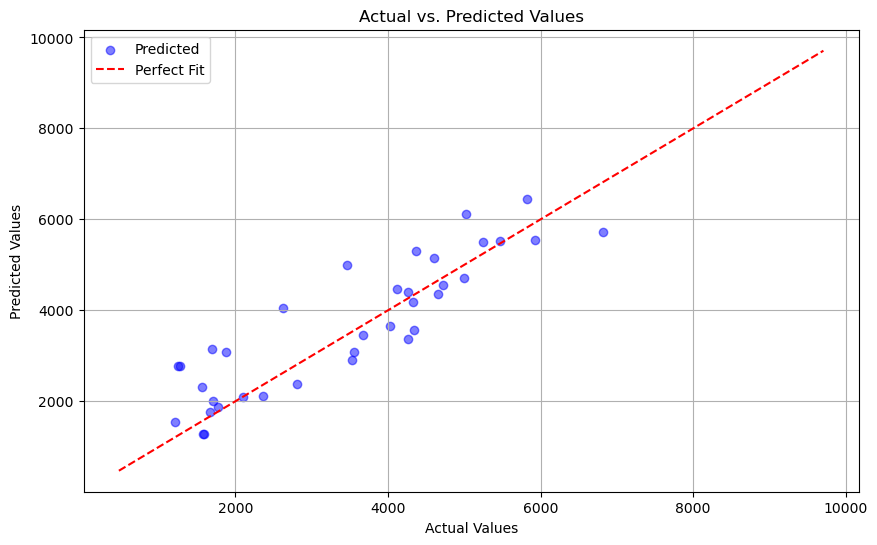

In [72]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted')
min_val = min(y_train.min(), y_pred.min())
max_val = max(y_train.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

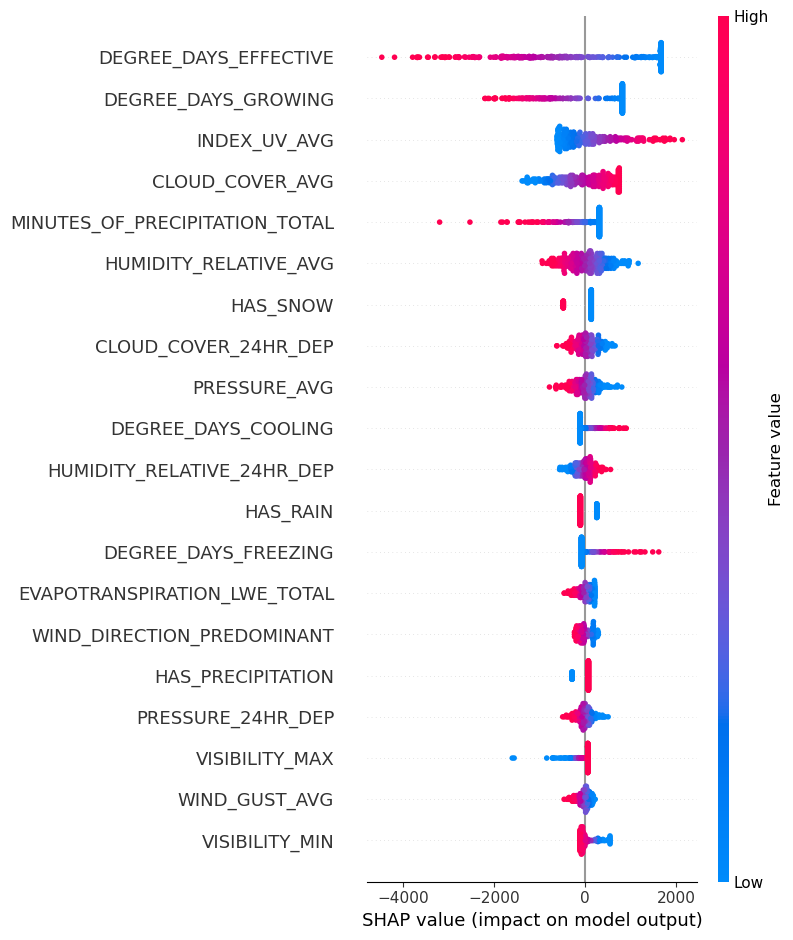

Top features based on SHAP values:
                           Feature shap_importance
8            DEGREE_DAYS_EFFECTIVE     1463.915926
10             DEGREE_DAYS_GROWING      915.169881
17                    INDEX_UV_AVG      497.639566
4                  CLOUD_COVER_AVG      477.331363
18  MINUTES_OF_PRECIPITATION_TOTAL       379.39544
15           HUMIDITY_RELATIVE_AVG      345.501701
26                        HAS_SNOW      202.037879
3             CLOUD_COVER_24HR_DEP      193.266885
24                    PRESSURE_AVG      190.466871
7              DEGREE_DAYS_COOLING      169.484858
14      HUMIDITY_RELATIVE_24HR_DEP      154.529193
25                        HAS_RAIN       153.46907
9             DEGREE_DAYS_FREEZING      150.287789
11    EVAPOTRANSPIRATION_LWE_TOTAL      125.171302
40      WIND_DIRECTION_PREDOMINANT      119.861144
20               HAS_PRECIPITATION      115.294164
23               PRESSURE_24HR_DEP      111.544324
36                  VISIBILITY_MAX      102.159

In [73]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['Feature', 'shap_importance']
importance_df_shap = importance_df.sort_values('shap_importance', ascending=False)

print("Top features based on SHAP values:")
print(importance_df_shap[:20])


### Interpertation
1. The most important feature is the "DEGREE_DAYS_EFFECTIVE".
2. "DEGREE_DAYS_GROWING" has a wide spread, indicating diverse effects on the model's predictions. 
3. Features with a dense clustering of dots, such as "INDEX_UV_AVG", have a more consistent impact on the model output, whereas wider distributions suggest that the feature's impact varies more across different data points. 
4. When "MINUTES_OF_PRECIPITATION_TOTAL" has higher values (shown in red), it tends to lower the model's predictions.

In [74]:
importance_features_shap = pd.DataFrame({
    'Feature': importance_df_shap.Feature,
    'Importance_shap': importance_df_shap.shap_importance
})

3. Decision Tree for Feature Selection

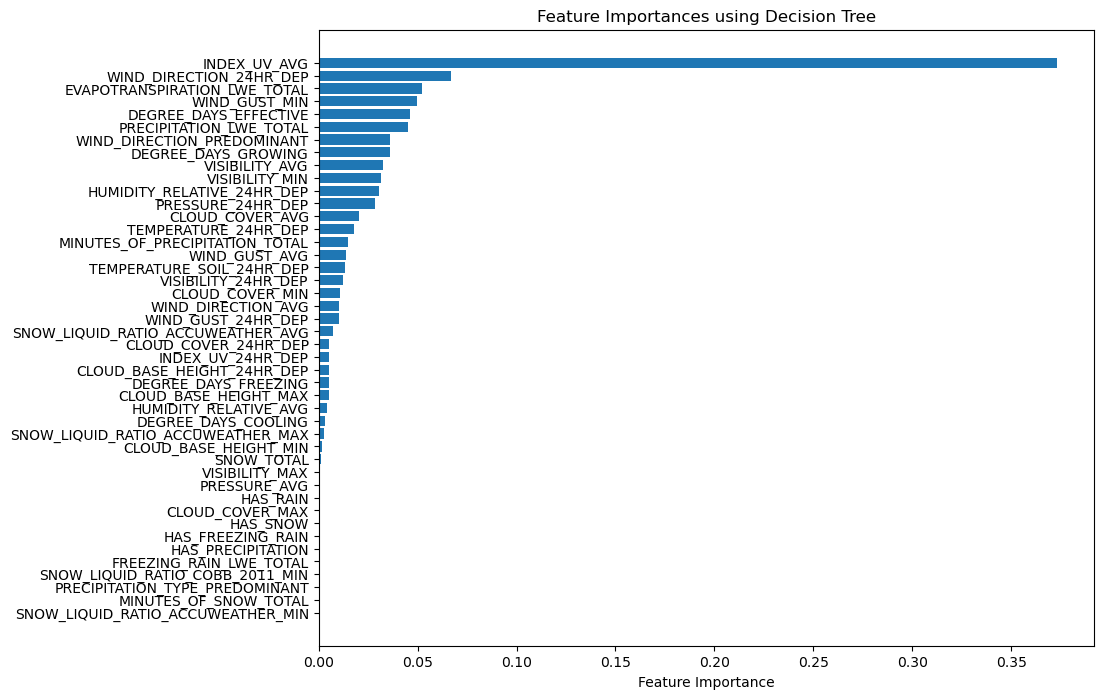

In [75]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
importances = tree_reg.feature_importances_

indices = np.argsort(importances)[::-1]
sorted_feature_names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), sorted_feature_names)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Feature Importances using Decision Tree')
plt.show()

In [76]:
feature_importances = tree_reg.feature_importances_
feature_names = X_train.columns
importance_df_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_DT': importances
})
importance_df_dt.sort_values(by='Importance_DT', ascending=False, inplace=True)

Choosing the top features by performing the intersection among these features.

In [77]:
importance_features_shap_20=importance_df_shap[:30]
important_features_mutual_info_20 = important_features_mutual_info[:30]
importance_df_dt_20 = importance_df_dt[:30]
dummy = pd.merge(important_features_mutual_info_20,importance_features_shap_20,on='Feature',how = 'inner')
TopFeatures=pd.merge(importance_df_dt_20,dummy,on='Feature',how = 'inner')

selected_features = TopFeatures.Feature[:15]

In [78]:
final_data = data[selected_features]
final_data.loc[:, "ESTIMATED_VISITS"] = data['ESTIMATED_VISITS']
# pd.merge(final_data,)
final_data.to_csv("final_data.csv",index = False)

Let's find the dataset that doesn't have the 'ESTIMATED_VISITS' data, which essentially serves as our model prediction test data in the final step.

In [79]:
unseen_data = df.merge(visits, on='DATE', how='left', indicator=True).loc[lambda x : x['_merge']=='left_only']
unseen_data = unseen_data[df.columns]
unseen_data[selected_features]

INDEX_UV_AVG  EVAPOTRANSPIRATION_LWE_TOTAL  WIND_GUST_MIN  \
0             1.12                       1.02000           4.30   
1             0.82                       1.91100           5.55   
2             1.15                       1.69400           5.42   
3             0.43                       1.04300           3.11   
4             0.62                       0.04000           2.49   
...            ...                           ...            ...   
1091          1.00                       1.44939           6.03   
1092          0.23                       0.35189           2.94   
1093          0.27                       0.58907           2.70   
1094          1.06                       1.23594           2.06   
1095          0.96                       0.61112           0.31   

      DEGREE_DAYS_EFFECTIVE  PRECIPITATION_LWE_TOTAL  \
0                     21.10                  0.00000   
1                     21.50                  0.00000   
2                     25.35                  0.00000   
3                     20.45                  0.00000   
4                     17.52                  0.00000   
...                     ...                      ...   
1091                  15.12                  0.00000   
1092                  12.66                 11.45771   
1093                  20.16                  2.51460   
1094                  16.89                  0.25400   
1095                  15.79                  0.00000   

      WIND_DIRECTION_PREDOMINANT  DEGREE_DAYS_GROWING  VISIBILITY_AVG  \
0                          265.1                  0.0          16.000   
1                          325.9                  0.0          15.971   
2                           38.4                  0.0          16.000   
3                           80.3                  0.0          15.821   
4                           54.8                  0.0          15.129   
...                          ...                  ...             ...   
1091                        69.7                  0.0          14.610   
1092                       258.0                  0.0          13.206   
1093                       306.6                  0.0          13.323   
1094                       290.7                  0.0          14.547   
1095                       262.5                  0.0          14.484   

      VISIBILITY_MIN  PRESSURE_24HR_DEP  CLOUD_COVER_AVG  \
0             16.000             428.32             0.18   
1             15.550            -230.48             0.15   
2             16.000             770.80             0.33   
3             15.227           -1217.38             0.88   
4             13.988            -186.98             0.81   
...              ...                ...              ...   
1091          14.484            -159.46             0.50   
1092           4.828           -1515.10             0.98   
1093           2.816            -161.40             0.96   
1094          14.484            1000.89             0.19   
1095          14.484            -246.87             0.05   

      MINUTES_OF_PRECIPITATION_TOTAL  WIND_GUST_AVG  CLOUD_COVER_MIN  \
0                                  0           8.59             0.00   
1                                  0          11.76             0.00   
2                                  0           7.78             0.00   
3                                  0           8.73             0.45   
4                                  0           4.05             0.47   
...                              ...            ...              ...   
1091                               0          11.34             0.00   
1092                             660           5.83             0.76   
1093                             360          10.89             0.82   
1094                              60          10.45             0.00   
1095                               0           2.26             0.00   

      WIND_DIRECTION_AVG  
0                  277.0  
1          

# Model Prediction

In [145]:
X = data[selected_features[:10]]
y = data['ESTIMATED_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X

INDEX_UV_AVG  EVAPOTRANSPIRATION_LWE_TOTAL  WIND_GUST_MIN  \
0            0.80                         2.821           9.79   
2            0.59                         0.892           3.04   
3            1.52                         0.094           2.38   
4            0.77                         0.098           2.91   
5            0.69                         0.151           3.26   
..            ...                           ...            ...   
359          0.38                         4.202           9.78   
360          0.46                         3.664           9.18   
361          1.14                         1.323           3.96   
362          0.33                         0.810           3.88   
363          0.89                         0.267           4.33   

     DEGREE_DAYS_EFFECTIVE  PRECIPITATION_LWE_TOTAL  \
0                    21.07                    0.000   
2                    17.07                    0.638   
3                    13.27                    0.000   
4                    13.39                    0.000   
5                    14.97                    0.000   
..                     ...                      ...   
359                  24.38                    0.000   
360                  28.24                    0.000   
361                  22.04                    0.000   
362                  19.96                    8.364   
363                  13.14                   10.013   

     WIND_DIRECTION_PREDOMINANT  DEGREE_DAYS_GROWING  VISIBILITY_AVG  \
0                         333.0                  0.0          16.000   
2                         212.3                  0.0          15.928   
3                         337.1                  0.0          15.773   
4                         325.6                  0.0          15.761   
5                          67.0                  0.0          15.502   
..                          ...                  ...             ...   
359                       300.6                  0.0          15.751   
360                       316.2                  0.0          16.000   
361                       310.4                  0.0          16.000   
362                        95.7                  0.0          15.338   
363                       209.5                  0.0          15.378   

     VISIBILITY_MIN  PRESSURE_24HR_DEP  
0            16.000             803.27  
2            15.263            -346.58  
3            15.348            -395.19  
4            15.382             -66.20  
5            15.028            -330.02  
..              ...                ...  
359          14.707            1166.29  
360          16.000             906.71  
361          16.000             568.23  
362          13.025           -1073.85  
363          14.633           -1984.97  

[357 rows x 10 columns]

In [126]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    r2_square = r2_score(true, predicted)
    return mae, mse, r2_square

In [161]:
#creating a basic model to understand the working 
## Beginning Model Training 
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    model_train_mae , model_train_mse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_mse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Mean Squared Error: 2004030.4431
- Mean Absolute Error: 1080.8199
- R2 Score: 0.4358
----------------------------------
Model performance for Test set
- Mean Squared Error: 719040.5695
- Mean Absolute Error: 738.1111
- R2 Score: 0.7193


Random Forest Regressor
Model performance for Training set
- Mean Squared Error: 277371.7456
- Mean Absolute Error: 387.9892
- R2 Score: 0.9219
----------------------------------
Model performance for Test set
- Mean Squared Error: 540314.3766
- Mean Absolute Error: 510.7183
- R2 Score: 0.7891




Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=  

[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=log2, m

[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, 

[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=15, max_features=l

[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, mi

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, max_featur

[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, mi

[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min

[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=

[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_

[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt,

Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error: 428213.76986564934
R^2 Score Test: 0.8328453597092318
R^2 Score Train: 0.8630046804514915


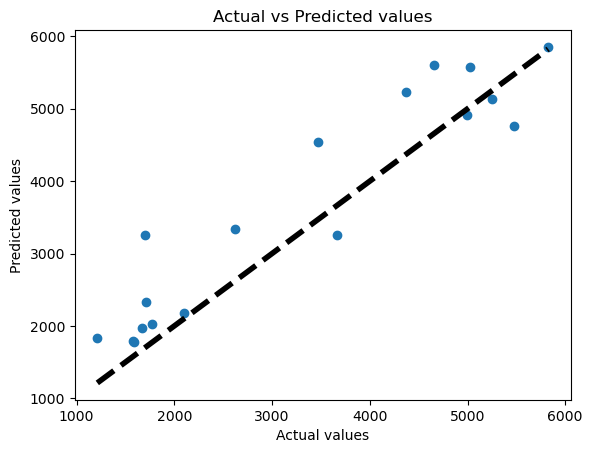

In [146]:
#These are the set of hyperparameters
param_grid = {
    'n_estimators': [10, 20, 50, 100,300, 500],
    'max_features': [ 'log2', 'sqrt'],
    'max_depth': [2,4,8,10, 15,20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
#using the best hyperparameters obtained from grid search we perform the predcition
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score Test: {r2}")
print(f"R^2 Score Train: {r2_train}")


plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()


Let's utilize the model parameters on the unseen data we obtained earlier. This involves generating estimates of visitations for data that was previously unavailable for in ESTIMATED_VISITS Column.

In [149]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(unseen_data[selected_features[:10]])
print(y_pred)

[3616.83827553 3424.71114065 3207.64437521 2447.59082606 3135.13212713
 2513.99362498 2927.87434416 4226.02612412 4276.37039583 4197.154591
 3596.18776919 4529.88047758 4958.10713509 2964.97538059 3521.02176984
 2698.16688548 2388.70382932 5683.25039671 3257.08980721 5768.5050178
 2365.81851719 3170.92843365 2597.62064621 2503.09059935 3219.15542385
 3237.3639558  4235.13700549 4647.46575549 2864.69879956 2699.98532798
 2846.02451829 4701.10220238 3318.51098664 4772.55006746 4155.59121413
 3871.60688404 3287.7811685  2713.74677668 2799.57351245 3600.47003357
 3140.18360171 4790.90725    3485.68304845 4344.10342687 3821.93389069
 3524.21529493 2789.25221658 3342.58381135 5977.99335131 6016.84045688
 2848.17559982 3634.99746337 2842.33762302 3857.18624845 5561.9780754
 5842.81775594 5214.35166565 5681.74432179 5863.0914632  5714.04630262
 6283.76983631 6524.06166227 6469.68023893 6053.46067111 6379.71571079
 3440.68658811 4245.02244133 3977.40295137 3691.4221135  4848.72470055
 5052.6930

### Summary :

- The project began with initial data cleaning, setting a strong foundation for accurate analysis. Subsequent exploratory data analysis (EDA) provided a deeper understanding of the dataset's characteristics and underlying patterns. 
- Feature engineering techniques such as the mutual information regression, SHAP (SHapley Additive exPlanations), and decision tree regression, were employed to identify significant features. An intersection of the top features identified by these methods was performed, narrowing the focus to the 20 most influential features. 
- A Random Forest algorithm was selected for building the model, utilizing the top 10 features which resulted in an R-squared score of 83.28%.

#### Insights 
- The model proves versatile with potential applications in predicting visitor numbers for future events or estimating the impact of planned constructions on visitation. This predictive capability is vital for operational planning and resource allocation in various scenarios.

- Exploring further enhancements to the project could yield even greater accuracy and applicability of the model. Diving deeper into feature engineering with an emphasis on incorporating domain-specific features could sharpen the model's precision, subtly capturing intricacies that general features might overlook. 
- Experimenting with cutting-edge machine learning algorithms such as LightGBM and XGBoost might also refine the model’s robustness and predictive power. 